In [1]:
#Importing necessary modules
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

This is followed by checking some dataset, its shape and statistics. As can be seen there are 4 columns and 21293 rows.

In [2]:
data=pd.read_csv('BreadBasket_DMS.csv')
data.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


In [3]:
data.shape

(21293, 4)

In [4]:
data.describe()

,Transaction
count,21293.000000
mean,4951.990889
std,2787.758400
min,1.000000
25%,2548.000000
50%,5067.000000
75%,7329.000000
max,9684.000000


In [5]:
data.shape

(21293, 4)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
Date           21293 non-null object
Time           21293 non-null object
Transaction    21293 non-null int64
Item           21293 non-null object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


While exploring this dataset, I found that although there was no evident null value, some of the items (786)  were labeled as 'NONE'.  So, I removed these items from the data.

In [7]:
data.loc[data['Item']=='NONE',:].count()

Date           786
Time           786
Transaction    786
Item           786
dtype: int64

In [8]:
data=data.drop(data.loc[data['Item']=='NONE'].index)

Next question that comes up is- how many items is this bakery selling? And the answer is that this bakery menu contains 94 items and the best seller among them is Coffee.

In [9]:
data['Item'].nunique()

94

In [10]:
data['Item'].value_counts().sort_values(ascending=False).head(10)

Coffee           5471
Bread            3325
Tea              1435
Cake             1025
Pastry            856
Sandwich          771
Medialuna         616
Hot chocolate     590
Cookies           540
Brownie           379
Name: Item, dtype: int64

Text(0.5,1,'Best sellers')

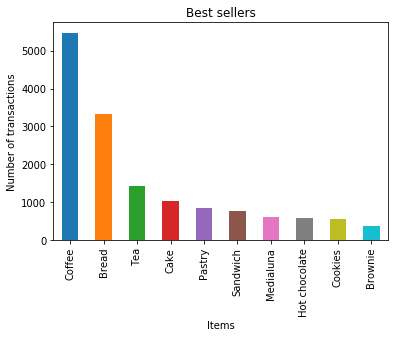

In [11]:
fig, ax=plt.subplots(figsize=(6,4))
data['Item'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.ylabel('Number of transactions')
plt.xlabel('Items')
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.title('Best sellers')

Next interesting thing to find out is that when is the bakery doing the most business during the day. Here, it seems that the bakery is most busy during afternoon and morning and has little business during evening and night.

In [12]:
data.loc[(data['Time']<'12:00:00'),'Daytime']='Morning'
data.loc[(data['Time']>='12:00:00')&(data['Time']<'17:00:00'),'Daytime']='Afternoon'
data.loc[(data['Time']>='17:00:00')&(data['Time']<'21:00:00'),'Daytime']='Evening'
data.loc[(data['Time']>='21:00:00')&(data['Time']<'23:50:00'),'Daytime']='Night'

Text(0.5,1,'Business during the day')

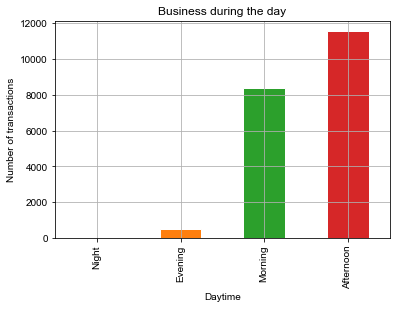

In [13]:
fig, ax=plt.subplots(figsize=(6,4))
sns.set_style('darkgrid')
data.groupby('Daytime')['Item'].count().sort_values().plot(kind='bar')
plt.ylabel('Number of transactions')
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.title('Business during the day')

During its nearly 6 months in business, this bakery has sold over 11569 items during afternoon and only 14 items during night hours.

In [14]:
data.groupby('Daytime')['Item'].count().sort_values(ascending=False)

Daytime
Afternoon    11569
Morning       8404
Evening        520
Night           14
Name: Item, dtype: int64

For further analysis, I needed to extract month and day from the dataset which is done as shown below.

In [15]:
data['Date_Time']=pd.to_datetime(data['Date']+' '+data['Time'])
data['Day']=data['Date_Time'].dt.day_name()
data['Month']=data['Date_Time'].dt.month
data['Month_name']=data['Date_Time'].dt.month_name()
data['Year']=data['Date_Time'].dt.year
data['Year_Month']=data['Year'].apply(str)+' '+data['Month_name'].apply(str)
data.drop(['Date','Time'], axis=1, inplace=True)

data.index=data['Date_Time']
data.index.name='Date'
data.drop(['Date_Time'],axis=1,inplace=True)
data.head()

,Transaction,Item,Daytime,Day,Month,Month_name,Year,Year_Month
Date,,,,,,,,
2016-10-30 09:58:11,1,Bread,Morning,Sunday,10,October,2016,2016 October
2016-10-30 10:05:34,2,Scandinavian,Morning,Sunday,10,October,2016,2016 October
2016-10-30 10:05:34,2,Scandinavian,Morning,Sunday,10,October,2016,2016 October
2016-10-30 10:07:57,3,Hot chocolate,Morning,Sunday,10,October,2016,2016 October
2016-10-30 10:07:57,3,Jam,Morning,Sunday,10,October,2016,2016 October


The plot shows the performance of bakery during different months of its short existence. October and April showed less business which was due to few number of operational days in these months- 2 and 7 respectively.

Text(0.5,1,'Business during the past months')

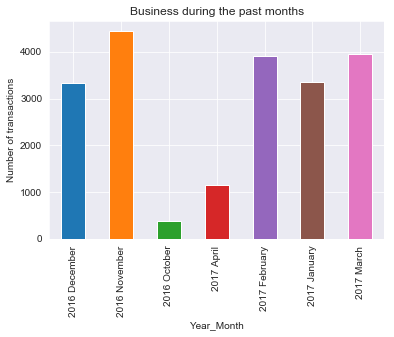

In [16]:
data.groupby('Year_Month')['Item'].count().plot(kind='bar')
plt.ylabel('Number of transactions')
plt.title('Business during the past months')

In [17]:
data.loc[data['Year_Month']=='2016 October'].nunique()

Transaction    175
Item            30
Daytime          3
Day              2
Month            1
Month_name       1
Year             1
Year_Month       1
dtype: int64

In [18]:
data.loc[data['Year_Month']=='2017 April'].nunique()

Transaction    509
Item            49
Daytime          4
Day              7
Month            1
Month_name       1
Year             1
Year_Month       1
dtype: int64

Next, I was interested in finding out monthly bestseller. This table below shows not only the item that has maximum buyers but one can also check how many quantities of their items of interest  were sold . As expected, coffee is the topseller in all the months.

In [19]:
data2=data.pivot_table(index='Month_name',columns='Item', aggfunc={'Item':'count'}).fillna(0)
data2['Max']=data2.idxmax(axis=1)
data2


Item                                                     \
Item       Adjustment Afternoon with the baker Alfajores Argentina Night   
Month_name                                                                 
April             0.0                      2.0      24.0             5.0   
December          0.0                      0.0      45.0             0.0   
February          0.0                     13.0     112.0             0.0   
January           0.0                     15.0      39.0             0.0   
March             0.0                     14.0       8.0             2.0   
November          1.0                      0.0     141.0             0.0   
October           0.0                      0.0       0.0             0.0   

                                                                 \
Item       Art Tray Bacon Baguette Bakewell Bare Popcorn Basket   
Month_name                                                        
April           1.0   0.0     11.0      0.0          0.0    0.0   
December        6.0   0.0      0.0      8.0          3.0    0.0   
February        5.0   0.0     60.0      1.0          2.0    0.0   
January         5.0   0.0     20.0     10.0          0.0    0.0   
March           3.0   0.0     61.0     19.0          0.0    0.0   
November       18.0   1.0      0.0     10.0          0.0    4.0   
October         0.0   0.0      0.0      0.0          0.0    2.0   

                 ...                                               \
Item             ...       The Nomad Tiffin Toast Truffles Tshirt   
Month_name       ...                                                
April            ...             8.0   20.0  22.0     22.0    0.0   
December         ...            10.0    0.0  65.0     27.0    0.0   
February         ...            12.0   26.0  72.0     37.0   21.0   
January          ...            15.0   36.0  79.0     30.0    0.0   
March            ...            10.0   57.0  80.0     48.0    0.0   
November         ...             3.0    7.0   0.0     29.0    0.0   
October          ...             0.0    0.0   0.0      0.0    0.0   

                                                                         \
Item       Valentine's card Vegan Feast Vegan mincepie Victorian Sponge   
Month_name                                                                
April                   0.0         7.0            0.0              0.0   
December                0.0         0.0           33.0              0.0   
February               12.0         3.0            5.0              0.0   
January                 1.0         0.0           13.0              0.0   
March                   0.0         6.0            3.0              0.0   
November                0.0         0.0            0.0              4.0   
October                 0.0         0.0            0.0              3.0   

                       Max  
Item                        
Month_name                  
April       (Item, Coffee)  
December    (Item, Coffee)  
February    (Item, Coffee)  
January     (Item, Coffee)  
March       (Item, Coffee)  
November    (Item, Coffee)  
October     (Item, Coffee)  

[7 rows x 95 columns]

Here, I checked for the daytime bestseller. Coffee top the charts during morning, afternoon and evening, but for obvious reasons it is not the favourite during night. Vegan feast is the best seller for nights.

In [20]:
data3=data.pivot_table(index='Daytime',columns='Item', aggfunc={'Item':'count'}).fillna(0)
data3['Max']=data3.idxmax(axis=1)
data3

Item                                                     \
Item      Adjustment Afternoon with the baker Alfajores Argentina Night   
Daytime                                                                   
Afternoon        0.0                     19.0     245.0             3.0   
Evening          1.0                     15.0      17.0             0.0   
Morning          0.0                     10.0     107.0             4.0   
Night            0.0                      0.0       0.0             0.0   

                                                                \
Item      Art Tray Bacon Baguette Bakewell Bare Popcorn Basket   
Daytime                                                          
Afternoon     31.0   1.0     67.0     30.0          4.0    0.0   
Evening        2.0   0.0      1.0      0.0          1.0    0.0   
Morning        5.0   0.0     84.0     18.0          0.0    6.0   
Night          0.0   0.0      0.0      0.0          0.0    0.0   

                  ...                                                   \
Item              ...          The Nomad Tiffin  Toast Truffles Tshirt   
Daytime           ...                                                    
Afternoon         ...               31.0   93.0  114.0    152.0    0.0   
Evening           ...                1.0    4.0    0.0      7.0   21.0   
Morning           ...               26.0   49.0  204.0     34.0    0.0   
Night             ...                0.0    0.0    0.0      0.0    0.0   

                                                                        \
Item      Valentine's card Vegan Feast Vegan mincepie Victorian Sponge   
Daytime                                                                  
Afternoon              4.0         4.0           30.0              5.0   
Evening                4.0         3.0            2.0              0.0   
Morning                3.0         2.0           22.0              2.0   
Night                  2.0         7.0            0.0              0.0   

                           Max  
Item                            
Daytime                         
Afternoon       (Item, Coffee)  
Evening         (Item, Coffee)  
Morning         (Item, Coffee)  
Night      (Item, Vegan Feast)  

[4 rows x 95 columns]

As expected, Coffee is the best seller from Monday to Sunday.

In [21]:
data4=data.pivot_table(index='Day',columns='Item', aggfunc={'Item':'count'}).fillna(0)
data4['Max']=data4.idxmax(axis=1)
data4

Item                                                     \
Item      Adjustment Afternoon with the baker Alfajores Argentina Night   
Day                                                                       
Friday           0.0                      7.0      59.0             0.0   
Monday           0.0                      5.0      32.0             0.0   
Saturday         0.0                     12.0      67.0             5.0   
Sunday           0.0                     14.0      70.0             1.0   
Thursday         0.0                      2.0      57.0             1.0   
Tuesday          0.0                      2.0      43.0             0.0   
Wednesday        1.0                      2.0      41.0             0.0   

                                                                \
Item      Art Tray Bacon Baguette Bakewell Bare Popcorn Basket   
Day                                                              
Friday         4.0   0.0     21.0      3.0          0.0    0.0   
Monday         2.0   0.0     10.0      8.0          0.0    0.0   
Saturday       5.0   0.0     33.0      8.0          0.0    3.0   
Sunday         7.0   1.0     21.0     11.0          0.0    3.0   
Thursday       8.0   0.0     21.0      3.0          4.0    0.0   
Tuesday        6.0   0.0     23.0     13.0          0.0    0.0   
Wednesday      6.0   0.0     23.0      2.0          1.0    0.0   

                ...                                               \
Item            ...       The Nomad Tiffin Toast Truffles Tshirt   
Day             ...                                                
Friday          ...             6.0   37.0  63.0     33.0    0.0   
Monday          ...             5.0    3.0  38.0     29.0    0.0   
Saturday        ...            24.0   35.0  53.0     46.0   21.0   
Sunday          ...            15.0   28.0  36.0     23.0    0.0   
Thursday        ...             3.0   25.0  53.0     23.0    0.0   
Tuesday         ...             2.0    5.0  40.0     19.0    0.0   
Wednesday       ...             3.0   13.0  35.0     20.0    0.0   

                                                                        \
Item      Valentine's card Vegan Feast Vegan mincepie Victorian Sponge   
Day                                                                      
Friday                 1.0         1.0            9.0              0.0   
Monday                 0.0         0.0            5.0              0.0   
Saturday               7.0        10.0           11.0              1.0   
Sunday                 0.0         2.0            9.0              4.0   
Thursday               3.0         0.0            7.0              0.0   
Tuesday                2.0         2.0            8.0              1.0   
Wednesday              0.0         1.0            5.0              1.0   

                      Max  
Item                       
Day                        
Friday     (Item, Coffee)  
Monday     (Item, Coffee)  
Saturday   (Item, Coffee)  
Sunday     (Item, Coffee)  
Thursday   (Item, Coffee)  
Tuesday    (Item, Coffee)  
Wednesday  (Item, Coffee)  

[7 rows x 95 columns]

I was curious about the business growth of this bakery. For that I have plotted some line plots. As observed above in the barplot, November showed maximum business for the bakery, followed by February and March, with a dip shown for December and January.

Text(0.5,1,'Business during the past months')

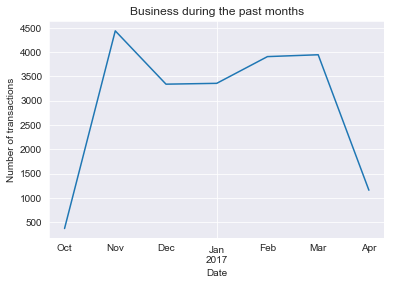

In [22]:
data['Item'].resample('M').count().plot()
plt.ylabel('Number of transactions')
plt.title('Business during the past months')

The next plot shows weekly performance of the bakery. A big dip in business is shown around end of December and start of first week of January

Text(0.5,1,'Weekly business during the past months')

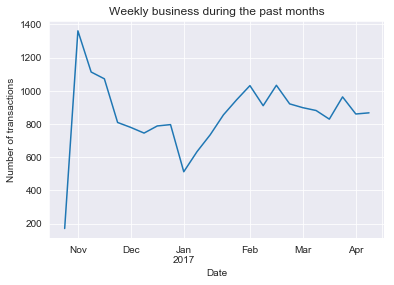

In [23]:
data['Item'].resample('W').count().plot()
plt.ylabel('Number of transactions')
plt.title('Weekly business during the past months')

I zoomed in to the daily performance of the bakery and found that there have been days around December end and January beginning when the bakery sold 0 item.

Text(0.5,1,'Daily business during the past months')

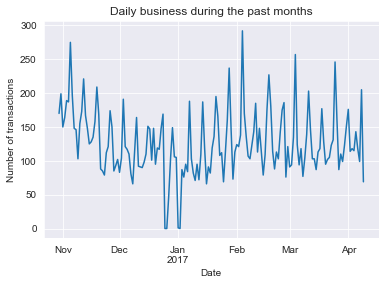

In [24]:
data['Item'].resample('D').count().plot()
plt.ylabel('Number of transactions')
plt.title('Daily business during the past months')

In [25]:
data['Item'].resample('D').count().min()

0

During the most profitable day the bakery could sell around 292 items and this happened in February (as seen in the daily graph above).  

In [26]:
data['Item'].resample('D').count().max()

292

### Apriori Algorithm and Association Rule:
Next, I plan to perform an association rule analysis which gives an idea about how things are associated to each other. The common metrics to measure association are-
1. Support- It is the measure of frequency or abundance of an item in a dataset. It can be 'antecedent support', 'consequent support', and 'support'. 'antecedent support' contains proportion of transactions done for the antecedent while 'consequent support' involves  those for consequent. 'Support' is computed for both antecedent and consequent in question.
2. Confidence-This gives the probability of consequent in a transaction given the presence of antecedent.
3. Lift- Given that antecedents and consequents are independent, how often do they come together/bought together.
4. Leverage- It is the difference between frequency of antecedent and consequent together in transactions to frequency of both in independent transactions.
5.Conviction- A higher conviction score means that consequent is highly dependent on antecedent.

Apriori algorithm is used to extract frequent itemsets that are further used for association rule analysis. In this algorithm, user defines a minimum support that is the minimum threshold that decides if an itemset is considered as 'frequent'. 

To begin with association rule analysis, I made a dataset that contains lists of items that are bought together.

In [27]:
lst=[]
for item in data['Transaction'].unique():
    lst2=list(set(data[data['Transaction']==item]['Item']))
    if len(lst2)>0:
        lst.append(lst2)
print(lst[0:3])
print(len(lst))

[['Bread'], ['Scandinavian'], ['Hot chocolate', 'Jam', 'Cookies']]
9465


For Apriori algorithm, this dataset needs to be one-hot encoded. This is done using TransactionEncoder as shown here, followed by apriori algorithm to get the frequent itemsets. Then association rules function is used which can take any metric. Here I have used 'lift' and specified minimum threshold as 1.    

In [28]:
te=TransactionEncoder()
te_data=te.fit(lst).transform(lst)
data_x=pd.DataFrame(te_data,columns=te.columns_)
print(data_x.head())

frequent_items= apriori(data_x, use_colnames=True, min_support=0.03)
print(frequent_items.head())

rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules.antecedents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules

   Adjustment  Afternoon with the baker  Alfajores  Argentina Night  Art Tray  \
0       False                     False      False            False     False   
1       False                     False      False            False     False   
2       False                     False      False            False     False   
3       False                     False      False            False     False   
4       False                     False      False            False     False   

   Bacon  Baguette  Bakewell  Bare Popcorn  Basket        ...         \
0  False     False     False         False   False        ...          
1  False     False     False         False   False        ...          
2  False     False     False         False   False        ...          
3  False     False     False         False   False        ...          
4  False     False     False         False   False        ...          

   The BART  The Nomad  Tiffin  Toast  Truffles  Tshirt  Valentine's card  \
0  

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,Cake,Coffee,0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
1,Coffee,Cake,0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905
2,Medialuna,Coffee,0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
3,Coffee,Medialuna,0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667
4,Pastry,Coffee,0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682
5,Coffee,Pastry,0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740
6,Sandwich,Coffee,0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384
7,Coffee,Sandwich,0.478394,0.071844,0.038246,0.079947,1.112792,0.003877,1.008807


Next I used NetworkX (a Python package for the creation and study of complex networks) to build a network graph to check association between antecedents and consequents obtained after association rule. As can be seen from it, coffee is a very popular item that goes well with pastry, cake, medialuna and sandwich sold in this bakery. So, if a person is buying any of the last four items the chances of buying a coffee is high (also the reverse is true i.e. if a person is buying a coffee then likelihood of her/him buying any of the 4 items is high).



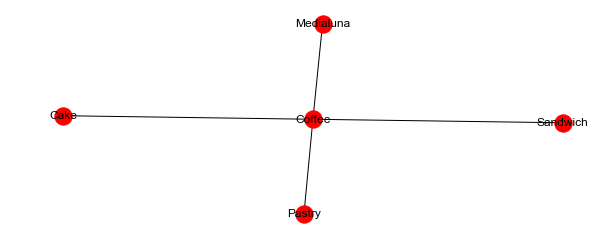

In [29]:
fig, ax=plt.subplots(figsize=(10,4))
GA=nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()


### Conclusion
Coffee is the bestseller of this bakery and it shows association with 4 items-  pastry, cake, medialuna and sandwich.
There are a couple of strategies that the bakery can adopt (if it isn't using them yet) to increase its sales considering the association we have seen between coffee and its 4 partners.
1. Promotional discount in either one of the 4 partners can entice customers to buy coffee (or the other way round, will also work).
2. Placing these 4 items close to coffee ordering counter can be a good strategy to attract customers in buying these (which we see quite often to happen in many bakeries and coffee shops).
3. How about some recipes like a coffee cake or coffee pastry? Will that entice coffe and cake/pastry lovers?? 
